In [253]:
import numpy as np
import random
import matplotlib.pyplot as plt


In [254]:

rest_lines = np.array([5000.0, 6000.0, 6500.0])   # H‑beta, [O III], H‑alpha-ish placeholders
amps       = np.array([1.0,   0.8,   0.6])        # relative line strengths/

In [255]:
wl = np.linspace(4800, 9000, 7000)

# Guassian:
# w: an array of values. Represents the wavelength.
# w0: represents the center of the peak where Gaussian is tallest.
# amp: the amplitude of the peak
# sigma: a small sigma makes the peak narrow and steep. 
# big sigma makes it wide and smooth
def gaussian(w, w0, amp, sigma=3.0):
    """Simple Gaussian line profile"""
    return amp * np.exp(-(w - w0)**2 / (2.0 * sigma**2))

#Zeros_like returns an array of zeros 
# with the same shape and size as a

# Build rest‑frame template spectrum
template_flux = np.zeros_like(wl)
for w0, amp in zip(rest_lines, amps):
    template_flux += gaussian(wl, w0, amp)


The equation looks like this:

$$ f(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^2} $$


$x$ represents the Variable

$\mu$ represents the Mean

$\sigma$ represents standard deviation

$e$ represents the base of the natural log.

properties of Gaussian Distribution:
    
-Symmetric around it's mean

-unimodal (one MODE) (means only one peak)

-Asymptotic

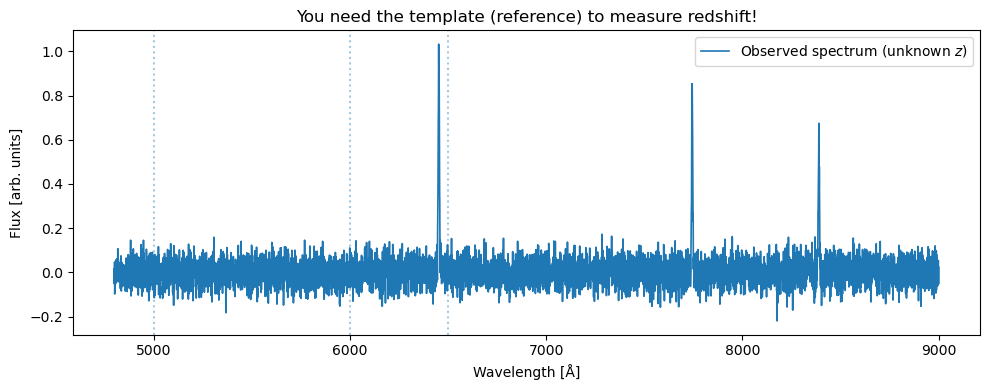

In [256]:
# ------------------------------------
# Apply a redshift to generate “data”
# ------------------------------------
z_true = np.random.rand(1)                    # the unknown redshift we’ll try to recover
obs_lines = (1.0 + z_true) * rest_lines

observed_flux = np.zeros_like(wl)
for w0, amp in zip(obs_lines, amps):
    observed_flux += gaussian(wl, w0, amp)

# Add a touch of noise so it looks more realistic
rng = np.random.default_rng(42)
observed_flux += 0.05 * rng.normal(size=wl.size)

# ------------------------------------
# Plot: template vs. observed spectrum
# ------------------------------------


plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux, label=f"Observed spectrum (unknown $z$)", linewidth=1.2)

    #plt.scatter(peaks, wl[peaks])
#plt.plot(wl, template_flux, '--', label="Template (rest‑frame)", linewidth=1.2)

# Mark the *rest* wavelengths (dotted) and observed wavelengths (dash‑dot)
for w_rest, w_obs in zip(rest_lines, obs_lines):
    plt.axvline(w_rest, linestyle=':', alpha=0.4)
    #plt.axvline(w_obs,  linestyle='-.', alpha=0.4)


plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [arb. units]")
plt.title("You need the template (reference) to measure redshift!")
plt.legend()
plt.tight_layout()
plt.show()



In a gauissian distribution:
    
    -68% of the values lie within 1 standard deviation of the mean
    (This is what it means when people say something is within "1sd")

    -95% of values lie within 2sd
    
    -99.7 lie within 3sd

So, to isolate the data that I want, I'm aiming to use 3 standard deviations or more to get rid of the 'noise'.

Below is a visual plot with the Gaussian Distribution that shows 1 standard deviation, 2 standard deviations, and 3 standard deviations.

For Gaussian Distribution, z-scores are used to measure how many standard deviations a data point is from the mean.

$$ z = \frac{x-\mu}{\sigma} $$

$x$ = value

$\mu$ = mean

$\sigma$ = standard deviation

3 or more standard deviations means z >= 3.

This is the general formula for the threshold beyond N standard deviations:

$$ x = \mu + n\sigma $$

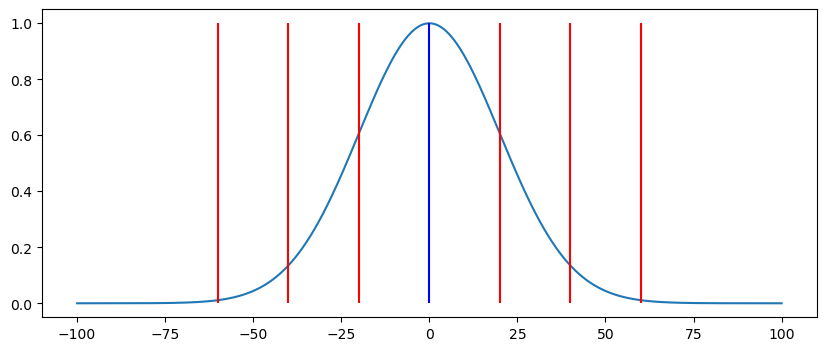

In [257]:
# The X and Y values for the plot below.

gaussianX = np.linspace(-100, 100, 3000)

sd = 20
mean = np.mean(gaussianX)

# Calculating gaussian Y values.
gaussianY = gaussian(mean, gaussianX, 1, sigma= sd)

plt.figure(figsize=(10, 4))
plt.plot(gaussianX, gaussianY)

# Below is the different standard deviation(s) from 1 to 3. The blue line is the mean.
plt.vlines(x=mean, colors=['b'], ymin=0, ymax=1)
for n in range(1, 4):
    plt.vlines(x=mean + n * sd, colors=['r'], ymin=0, ymax=1)
    plt.vlines(x=mean - n * sd, colors=['r'], ymin=0, ymax=1)


plt.show()


The reason as to why I did the above demonstration:

This was to show how much 3 or more standard deviations would be, and how much data I would be excluding.

So, when isolating the data that I want from the observed_flux, I would need to calculate the mean, then take the data that is the mean + 4 standard deviations. I did this because everything above the 'noise' is important, and below is not.

There's a upside and downside to choosing 4 standard deviations. The upside being it will get rid of noise, like I would like. The downside being it might miss subtle signals.

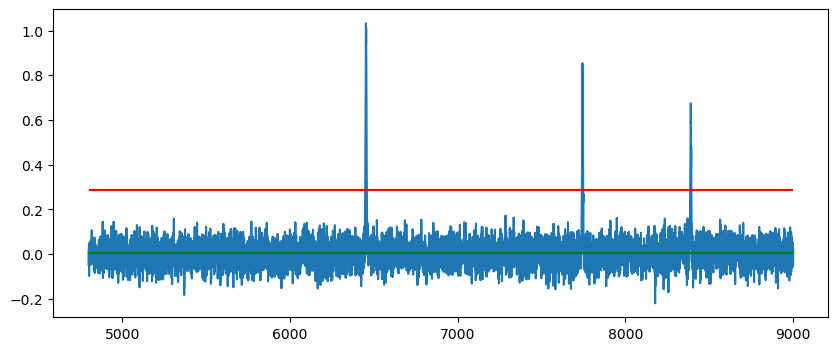

In [258]:
std = np.std(observed_flux)
mean = np.mean(observed_flux)

fourSTD = mean + 4 * std

plt.figure(figsize=(10, 4))
plt.plot(wl, observed_flux)\

plt.hlines(y=mean, colors=['g'], xmax=9000, xmin=4800)
plt.hlines(y = fourSTD, colors='r', xmax=9000, xmin=4800)



Everything above the red line I want to keep. So, I will add everything above the red line from observed_flux to another array. I will also keep track of the X values associated so later I can calculate redshift.

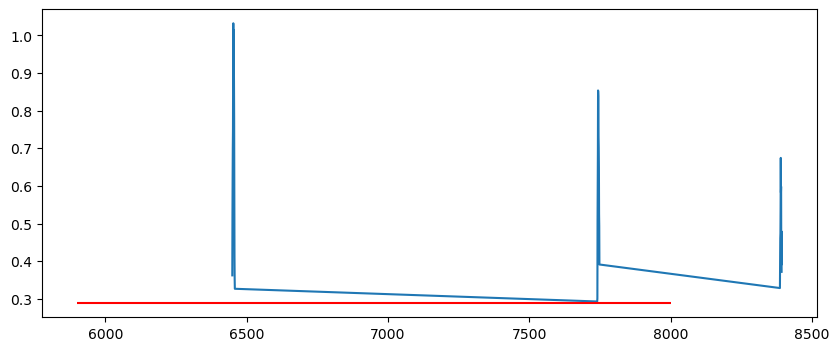

In [259]:
indices = np.where(fourSTD < observed_flux[:])

# Grabbing the places from observed_flux that are above the red line in the plot above.
eyObs_flux = observed_flux[indices]
# Grabbing the x values that correlate to the data above the red line.
exwl = wl[indices]

plt.figure(figsize=(10,4))
plt.plot(exwl, eyObs_flux)
plt.hlines(y=fourSTD, xmax=8000, xmin=5900, colors=['r'])

Above is the plot of all of the data I want to focus on. 

Next, I will group the moutains/peaks, as to not pick up any unwanted points when filtering for the top of each peak.

In [260]:
def find_moutains(yvals, xvals):
    moutains = []
    xmount = []

    for i in range(1, len(yvals) - 1):
        # finding a 'middle' of the moutian. 
        if yvals[i-1] < yvals[i] and yvals[i] > yvals[i+1]:
            #left egde
            left = i - 1
            while left > 0 and yvals[left - 1] < yvals[left]:
                left -= 1

            # Now for right edge
            right = i + 1
            
            while right < len(yvals) - 1 and yvals[right + 1] < yvals[right]:
                right += 1

            moutains.append(yvals[left:right + 1])
            xmount.append(xvals[left:right + 1])
    return moutains, xmount

In [261]:
# The above runs until it finds one of those 'middle' values, then I take that i value to find the left side first. While the left value is greater than 0, (as to not to throw 
# out of bounds), and the points im grabbing have a positive slope. Same thing with right but as long as it has a negative slope.
# I then append from the left index to the right index for both y values and x values.


6


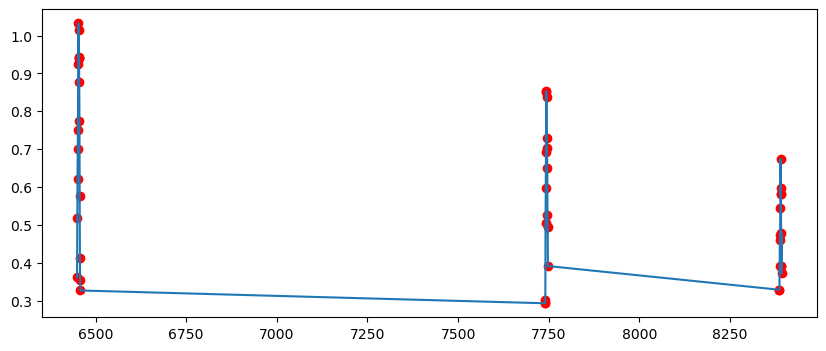

In [262]:
ymount, xmount = find_moutains(eyObs_flux, exwl)
print(len(ymount))
plt.figure(figsize=(10,4))
plt.plot(exwl, eyObs_flux)

for n in range(0, len(xmount)):
    plt.scatter(xmount[n], ymount[n], color='r')

In [263]:
# Now, to find the 'maximum' value in each of the sections of the array.
peaksY = []

indcD = []
for n in range(0, len(ymount)):
    #Find max. add to peaks of Y
    max = np.max(ymount[n])
    peaksY.append(max)
   
    #This was to find the indcies for the X.
    for i in range(0, len(ymount[n])):
        if(ymount[n][i] == max):
            indcD.append(i)    

peaksX = []
for i in range(0, len(xmount)):
    peaksX.append(xmount[i][indcD[i]])

print(peaksX)
print(peaksY)


[np.float64(6452.6360908701245), np.float64(6453.83626232319), np.float64(7742.820402914702), np.float64(8389.112730390056), np.float64(8390.312901843121), np.float64(8391.513073296184)]
[np.float64(1.0323183062512706), np.float64(1.013878185940486), np.float64(0.853684643654424), np.float64(0.674359413872284), np.float64(0.598222777285801), np.float64(0.47899217117171006)]


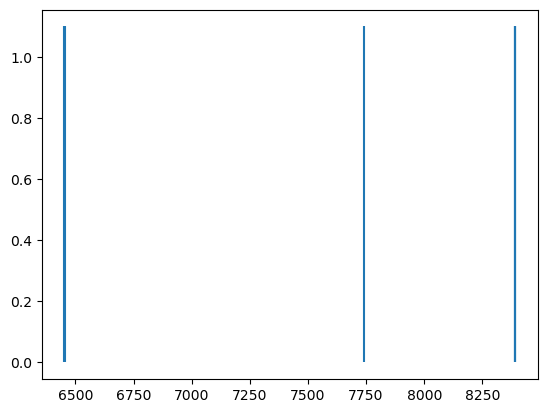

In [264]:
plt.vlines(x=peaksX, ymin=0, ymax=1.1)

In [265]:
# compare all the peaks found. calculate redshift and filter out the peaks that do not equally line up to the actually emitted lines.

In [266]:

# I'm just going to go ahead and calculate redshift. then I will find the closest numbers in each array.
def findRedshifts(xVals, rests):
    redshifts = []
    for i in range(0, len(rests)):
        tempArr = []
        for n in range(0, len(xVals)):
            z = abs(rests[i] - xVals[n]) / rests[i]
            tempArr.append(z)
        redshifts.append(tempArr)
    return redshifts

In [267]:
redshifts = findRedshifts(peaksX, rest_lines)
# print(redshifts[1])

# Not going to work how I want it to. ugh...


In [268]:

def find_closest(reds):
    row1, row2, row3 = reds
    mindif = float('inf')
    besttriple = []

    for i in range(len(row1)):
        for j in range(len(row2)):
            for k in range(len(row3)):
                a, b, c = row1[i], row2[j], row3[k]
                vals = [a, b, c]
                diff = np.max(vals) - np.min(vals)
                if diff < mindif:
                    mindif = diff
                    besttriple = [a, b, c]
    return besttriple


In [269]:
closestReds = find_closest(redshifts)


print(f'The three redshifts I found where: {closestReds}. The real redshift is:  {z_true}')

The three redshifts I found where: [np.float64(0.2905272181740249), np.float64(0.29047006715245033), np.float64(0.29063272775231624)]. The real redshift is:  [0.2906527]
